In [1]:
# !pip install -q rasterio
# !pip install -q geopandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 17.6 MB/s eta 0:00:00


In [2]:
import os

import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize

import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union

import numpy as np
import cv2
import matplotlib.pyplot as plt
import pyproj
from PIL import Image
from sklearn.model_selection import train_test_split

In [ ]:
raster_path = '/content/drive/MyDrive/Sed/T36UXV_20200406T083559_TCI_10m.jp2'
with rasterio.open(raster_path, "r", driver="JP2OpenJPEG") as src:
    raster_img = src.read()
    raster_meta = src.meta
    raster_crs = src.crs
print(raster_img.shape)

(3, 10980, 10980)


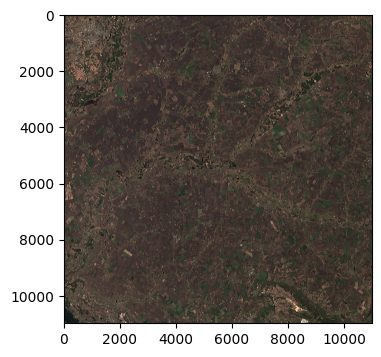

In [ ]:
raster_img = reshape_as_image(raster_img)
plt.figure(figsize=(4,4))
plt.imshow(raster_img)

In [ ]:
train_df = gpd.read_file('/content/drive/MyDrive/Sed/masks/Masks_T36UXV_20190427.shp')
train_df

ERROR:fiona._env:Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



,id,Data,Code,Descriptio,Comments,Image,geometry
0,NaN,NaN,2.0,branch of tree,NaN,T36UXV_20190427T083601,"POLYGON ((35.62916 49.60293, 35.63015 49.60163..."
1,NaN,NaN,1.0,color+ feathers,NaN,T36UXV_20190427T083601,"POLYGON ((35.65070 49.60254, 35.65248 49.60301..."
2,NaN,NaN,2.0,brahch of tree,NaN,T36UXV_20190427T083601,"POLYGON ((35.63023 49.60826, 35.62960 49.60920..."
3,NaN,NaN,1.0,color+ feathers,NaN,T36UXV_20190427T083601,"POLYGON ((35.62033 49.60905, 35.62064 49.60968..."
4,NaN,NaN,1.0,color+ feathers,NaN,T36UXV_20190427T083601,"POLYGON ((35.60455 49.61078, 35.60597 49.61228..."
...,...,...,...,...,...,...,...
931,NaN,NaN,1.0,color+ structure,NaN,T36UXV_20190427T083601,"POLYGON ((35.60033 49.04547, 35.60011 49.04496..."
932,NaN,NaN,1.0,color+ structure,NaN,T36UXV_20190427T083601,"POLYGON ((35.59042 49.04165, 35.59127 49.04155..."
933,NaN,NaN,1.0,color+ structure,NaN,T36UXV_20190427T083601,"POLYGON ((35.60754 49.05593, 35.60796 49.05600..."
934,NaN,NaN,1.0,color+ structure,NaN,T36UXV_20190427T083601,"POLYGON ((35.52378 48.76951, 35.52332 48.76918..."


In [ ]:
src = rasterio.open(raster_path, 'r')
failed = []
for num, row in train_df.iterrows():
    try:
        masked_image, out_transform = rasterio.mask.mask(src, [mapping(row['geometry'])], crop=True, nodata=0)
    except:
        failed.append(num)
print("Rasterio failed to mask {} files".format(len(failed)))

Rasterio failed to mask 936 files


In [ ]:
train_df = gpd.read_file('/content/drive/MyDrive/Sed/masks/Masks_T36UXV_20190427.shp')
train_df = train_df[train_df.geometry.notnull()]
train_df.crs = pyproj.CRS.from_epsg(4326)
train_df = train_df.to_crs(raster_crs)

ERROR:fiona._env:Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



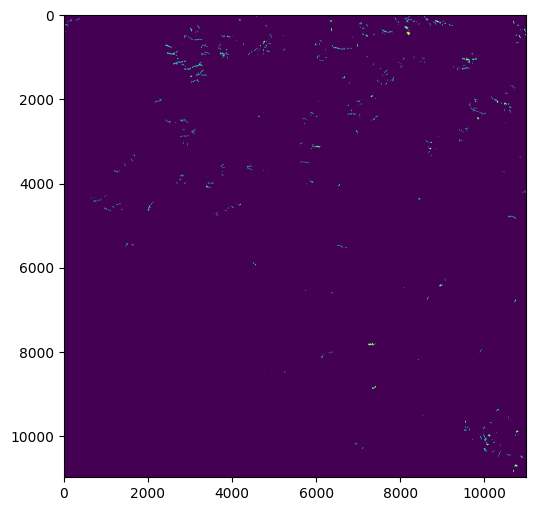

In [ ]:
def poly_from_utm(polygon, transform):
    poly_pts = []
    for i in np.array(polygon.exterior.coords):
        poly_pts.append(~transform * tuple(i))
    new_poly = Polygon(poly_pts)
    return new_poly

# creating binary mask for erosion/not_erosion segmentation.

poly_shp = []
im_size = (src.meta['height'], src.meta['width'])
for num, row in train_df.iterrows():
    if row['geometry'].geom_type == 'Polygon':
        poly = poly_from_utm(row['geometry'], src.meta['transform'])
        poly_shp.append(poly)
    else:
        for p in row['geometry']:
            poly = poly_from_utm(p, src.meta['transform'])
            poly_shp.append(poly)

mask = rasterize(shapes=poly_shp,
                 out_shape=im_size)

# plotting the mask

plt.figure(figsize=(6,6))
plt.imshow(mask)

In [ ]:
bin_mask_meta = src.meta.copy()
bin_mask_meta.update({'count': 1})
with rasterio.open('/content/drive/MyDrive/Sed/train.jp2', 'w', **bin_mask_meta) as dst:
    dst.write(mask * 255, 1)

In [151]:
with rasterio.open('/content/drive/MyDrive/Sed/train.jp2', "r", driver="JP2OpenJPEG") as src:
    mask = reshape_as_image(src.read())

with rasterio.open('/content/drive/MyDrive/Sed/T36UXV_20200406T083559_TCI_10m.jp2', "r", driver="JP2OpenJPEG") as src:
    raster_img = reshape_as_image(src.read())

In [152]:
print(f'percent of eroded soil in ds: {np.count_nonzero(mask)/mask.size}')

percent of eroded soil in ds: 0.0023956207842707887


## Data
This is an image segmentation task. What is noticable is huge imbalance between eroded field and the rest. First thing i have to do is adjust image size. I can do i by croping or resizing image. Also i have to divide it into patches. The problem is i need to remove patches with the small percetage of soil erosion. Larger patches will give network more context but at the same time i would lose more data. The oposite thing in case of smaller ones.

In [154]:
raster_img.shape,mask.shape

((10980, 10980, 3), (10980, 10980, 1))

In [161]:
def crop_image(image,mask,patch_size):
  size_x = (image.shape[1] // patch_size) * patch_size
  size_y = (image.shape[0] // patch_size) * patch_size
  image = Image.fromarray(image)
  image = np.array(image.crop((0, 0, size_x, size_y)))
  mask = Image.fromarray(mask)
  mask = np.array(mask.crop((0, 0, size_x, size_y)))
  return image,mask

def resize_image(image,mask,patch_size):
  size=image.shape[0]-(image.shape[0]%patch_size)
  size=(size,size)
  image = cv2.resize(image, size, interpolation = cv2.INTER_AREA)
  mask = cv2.resize(mask, size, interpolation = cv2.INTER_AREA)
  return image,mask

raster_resized,mask_resized=resize_image(raster_img,mask,256)
raster_cropped,mask_cropped=crop_image(raster_img,np.squeeze(mask,axis=2),256)

print(f'resized: {np.count_nonzero(mask_resized)/np.count_nonzero(mask_resized==0)}, cropped: {np.count_nonzero(mask_cropped)/np.count_nonzero(mask_cropped==0)}')

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (115605504 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


resized: 0.002692926302638406, cropped: 0.0024096572751134237


In [122]:
def patch_image(image,patch_size):
  patches = [image[j:j+patch_size, i:i+patch_size, :]
                    for j in range(0, image.shape[0], patch_size)
                    for i in range(0, image.shape[1], patch_size)]
  return np.array(patches)

In [141]:
def count_erosion_by_patch_size(mask,patch_size):
  patches=patch_image(mask,patch_size)
  temp=np.array([np.count_nonzero(patch) for patch in patches])
  # Remove empty patches and count again
  patches=patches[temp!=0]
  temp=np.array([np.count_nonzero(patch) for patch in patches])
  print(f'Patch size: {patch_size}, Samples: {patches.shape[0]}, Mean patch erosion: {np.round(np.mean(temp)*100/(patches.shape[1]**2),2)}%')

for el in [256,128,64,32]:
  count_erosion_by_patch_size(np.expand_dims(mask_resized,axis=2),el)

Patch size: 256, Samples: 269, Mean patch erosion: 1.76%
Patch size: 128, Samples: 501, Mean patch erosion: 3.78%
Patch size: 64, Samples: 949, Mean patch erosion: 7.99%
Patch size: 32, Samples: 1934, Mean patch erosion: 15.68%


So looking at the results i will test my model on cropped and resized image divide into patches of size 64 and 32. I would also like to remove samples where percent of eroded soild is close to 0.

In [144]:
def prepare_data(image,mask,patch_size,resize_function,threshold_percent):
  # Reshize/crop image
  adjusted_image,adjusted_mask=resize_function(image,mask,patch_size)
  # Patch image
  patched_image=patch_image(adjusted_image,patch_size)
  # patched_mask=patch_image(adjusted_mask,patch_size)
  patched_mask=patch_image(np.expand_dims(adjusted_mask,axis=2),patch_size)
  # Remove useless samples
  temp=np.array([np.count_nonzero(patch) for patch in patched_mask])
  threshold=(patch_size*patch_size)*threshold_percent
  patched_image=patched_image[temp>=threshold]
  patched_mask=patched_mask[temp>=threshold]
  return patched_image,patched_mask

In [167]:
def preprocess_and_save(patch_size):
  X,y=prepare_data(raster_img,mask,patch_size,resize_image,0.02)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  np.savez(f'/content/drive/MyDrive/Sed/data_resized_{patch_size}.npz', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
  X,y=prepare_data(raster_img,np.squeeze(mask,axis=2),patch_size,crop_image,0.05)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  np.savez(f'/content/drive/MyDrive/Sed/data_cropped_{patch_size}.npz', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

In [168]:
for el in [64,32]:
  preprocess_and_save(el)

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (119771136 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (120472576 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
